# __Credit Risk Data__

# Importing Required Libraries

In [1]:
# Standard Imports
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pickle

# Transformers
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler

# Modeling Evaluation
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score, confusion_matrix, classification_report
from IPython.display import display, Markdown

# Pipelines
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer

# Machine Learning
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier

# Importing The Dataset

In [7]:
df = pd.read_csv("CreditRiskData.csv")
df.head()

,GoodCredit,checkingstatus1,duration2,history3,purpose4,amount5,savings6,employ7,installment8,status9,...,residence11,property12,age13,otherplans14,housing15,cards16,job17,liable18,tele19,foreign20
0,0,A11,6,A34,A43,1169,A65,A75,4,A93,...,4,A121,67,A143,A152,2,A173,1,A192,A201
1,1,A12,48,A32,A43,5951,A61,A73,2,A92,...,2,A121,22,A143,A152,1,A173,1,A191,A201
2,0,A14,12,A34,A46,2096,A61,A74,2,A93,...,3,A121,49,A143,A152,1,A172,2,A191,A201
3,0,A11,42,A32,A42,7882,A61,A74,2,A93,...,4,A122,45,A143,A153,1,A173,2,A191,A201
4,1,A11,24,A33,A40,4870,A61,A73,3,A93,...,4,A124,53,A143,A153,2,A173,2,A191,A201


In [12]:
df.columns

Index(['GoodCredit', 'checkingstatus1', 'duration2', 'history3', 'purpose4',
       'amount5', 'savings6', 'employ7', 'installment8', 'status9', 'others10',
       'residence11', 'property12', 'age13', 'otherplans14', 'housing15',
       'cards16', 'job17', 'liable18', 'tele19', 'foreign20'],
      dtype='object')

### __Defining variables for the columns in the dataframe to perform a train test split__

In [13]:
numerical_columns = ["duration2","amount5","age13"]
categorical_columns = ["checkingstatus1" ,"history3","purpose4","savings6","employ7","installment8","status9","others10","residence11","property12" 
              ,"otherplans14","housing15","cards16","job17","liable18","tele19","foreign20"]

In [16]:
#Creating ss transformer to scale the continuous numerical data with StandardScaler()
ss = Pipeline(steps=[('ss', StandardScaler())])

#Creating ohe transformer to encode the categorical data with OneHotEncoder()
ohe = Pipeline(steps=[('ohe', OneHotEncoder(drop='first'))])

#Creating preprocess column transformer to combine the ss and ohe pipelines
preprocess = ColumnTransformer(
                    transformers=[
                        ('cont', ss, numerical_columns),
                        ('cat', ohe, categorical_columns)
                    ])

### __Creating evaluation function to plot a confusion matrix and return the accuracy, precision, recall, and f1 scores__

In [17]:
def evaluation(y, y_hat, title = 'Confusion Matrix'):
    cm = confusion_matrix(y, y_hat)
    precision = precision_score(y, y_hat)
    recall = recall_score(y, y_hat)
    accuracy = accuracy_score(y,y_hat)
    f1 = f1_score(y,y_hat)
    print('Recall: ', recall)
    print('Accuracy: ', accuracy)
    print('Precision: ', precision)
    print('F1: ', f1)
    sns.heatmap(cm,  cmap= 'PuBu', annot=True, fmt='g', annot_kws=    {'size':20})
    plt.xlabel('predicted', fontsize=18)
    plt.ylabel('actual', fontsize=18)
    plt.title(title, fontsize=18)
    
    plt.show();

###  __Performing train_test_split on the data__

In [19]:
X = df.drop(['GoodCredit'], axis=1)
y = df.GoodCredit
y = LabelEncoder().fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

### __Creating cross_validate function__

In [25]:
def cross_validate(classifier, cv):
    pipeline = Pipeline(steps=[
        ('preprocess', preprocess),
        ('classifier', classifier)
    ])
    train_acc = []
    test_acc = []
    for train_ind, val_ind in cv.split(X_train, y_train):
        X_t, y_t = X_train.iloc[train_ind], y_train[train_ind]
        pipeline.fit(X_t, y_t)
        y_hat_t = pipeline.predict(X_t)
        train_acc.append(accuracy_score(y_t, y_hat_t))
        X_val, y_val = X_train.iloc[val_ind], y_train[val_ind]
        y_hat_val = pipeline.predict(X_val)
        test_acc.append(accuracy_score(y_val, y_hat_val))
    print(evaluation(y_val, y_hat_val))
    print('Training Accuracy: {}'.format(np.mean(train_acc)))
    print('\n')
    print('Validation Accuracy: {}'.format(np.mean(test_acc)))
    print('\n')

### __with Decision Tree Classifier__

Recall:  0.4583333333333333
Accuracy:  0.6933333333333334
Precision:  0.5238095238095238
F1:  0.4888888888888889


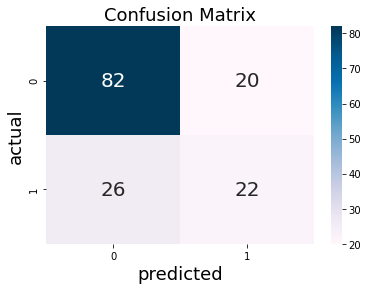

None
Training Accuracy: 1.0


Validation Accuracy: 0.6746666666666666




In [26]:
cross_validate(DecisionTreeClassifier(), KFold())

### __With K Nearest Neighbors classifier__

Recall:  0.25
Accuracy:  0.6466666666666666
Precision:  0.41379310344827586
F1:  0.31168831168831174


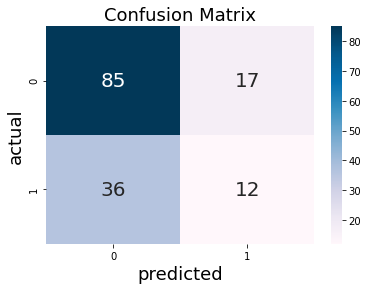

None
Training Accuracy: 0.7946666666666667


Validation Accuracy: 0.7013333333333331




In [27]:
cross_validate(KNeighborsClassifier(), KFold())

### __Pipeline With Grid Search__

In [30]:
def grid_search(classifier, param_grid, cv):
    search = GridSearchCV(Pipeline(steps=[
        ('preprocess', preprocess),
        ('classifier', classifier)
    ]), param_grid, cv=cv)
    train_acc = []
    test_acc = []
    for train_ind, val_ind in cv.split(X_train, y_train):
        X_t, y_t = X_train.iloc[train_ind], y_train[train_ind]
        search.fit(X_t, y_t)
        y_hat_t = search.predict(X_t)
        train_acc.append(accuracy_score(y_t, y_hat_t))
        X_val, y_val = X_train.iloc[val_ind], y_train[val_ind]
        y_hat_val = search.predict(X_val)
        test_acc.append(accuracy_score(y_val, y_hat_val))
    print(evaluation(y_val, y_hat_val))
    print('Training Accuracy: {}'.format(np.mean(train_acc)))
    print('\n')
    print('Validation Accuracy: {}'.format(np.mean(test_acc)))
    print('\n')
    print('Grid Search Best Params:')
    print('\n')
    print(search.best_params_)

### __GridSearchCV with Random Forest__

Recall:  0.3125
Accuracy:  0.7066666666666667
Precision:  0.5769230769230769
F1:  0.4054054054054054


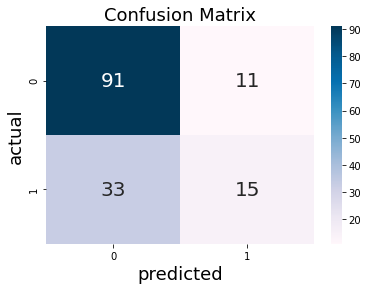

None
Training Accuracy: 0.986


Validation Accuracy: 0.728


Grid Search Best Params:


{'classifier__max_depth': 50, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}


In [33]:
#Creating parameter grid for Random Forest
rand_forest_parms = {'classifier__n_estimators': [100, 300, 500],
                     'classifier__max_depth':[6, 25, 50, 70],
                     'classifier__min_samples_split': [2, 5, 10],
                     'classifier__min_samples_leaf': [1, 2, 10]}
#Calling the grid_search function using the parameters above
grid_search(RandomForestClassifier(), rand_forest_parms, KFold())

### __Fitting final pipeline to X_train and y_train, and predicting on X_test__

Evaluation on training data 

Recall:  0.9649122807017544
Accuracy:  0.9893333333333333
Precision:  1.0
F1:  0.9821428571428572


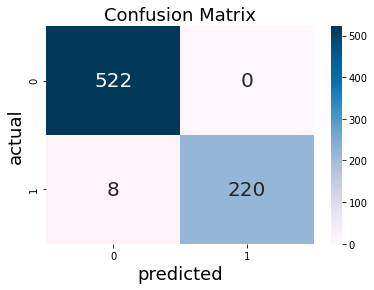

None


Evaluation on testing data 

Recall:  0.3194444444444444
Accuracy:  0.748
Precision:  0.6216216216216216
F1:  0.4220183486238532


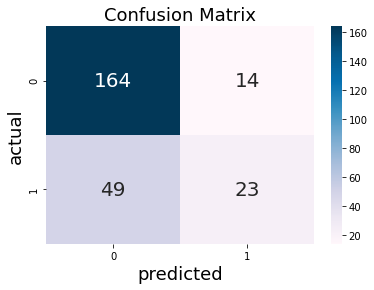

None


In [34]:
final_pipeline = GridSearchCV(Pipeline(steps=[
        ('preprocess', preprocess),
        ('classifier', RandomForestClassifier())
    ]), rand_forest_parms, cv=KFold())
#Fit and predict on train data
final_pipeline.fit(X_train, y_train)
train_pred = final_pipeline.best_estimator_.predict(X_train)
print('Evaluation on training data \n')
print(evaluation(y_train, train_pred))
print('\n')
#Predict on test data
test_pred = final_pipeline.best_estimator_.predict(X_test)
print('Evaluation on testing data \n')
print(evaluation(y_test, test_pred))